# Convolutional Neural Networks

**Goal:** Convolution & pooling, implement LeNet, an AlexNet-style model, and VGG (transfer learning). tips for applying CNNs to image data.

# 1 — Setup & Imports


In [ ]:
# Basic setup (run this first)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.19.0


In [ ]:
import random, os
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# 2 —Theory: Convolution and Pooling

```
Convolutional layer (Conv):
- Applies learnable filters (kernels) that slide across spatial dimensions.
- Each filter produces a feature map (activation map) that responds to a specific pattern.
- Important hyperparameters: number of filters, kernel size, stride, padding, activation.

```
Common patterns:
- (Conv -> Activation -> Conv -> Activation -> Pool) blocks
- Use BatchNorm and Dropout when helpful.


```
Pooling layer:
- Downsamples spatially (max-pooling, average-pooling).
- Reduces spatial size, reduces parameters and computation, adds translation invariance.

# 3 — Visualize example filters & feature maps (utility functions)

In [ ]:
def plot_images(images, titles=None, ncols=6, figsize=(12,6)):
    n = len(images)
    ncols = min(ncols, n)
    nrows = (n + ncols - 1) // ncols
    plt.figure(figsize=figsize)
    for i, img in enumerate(images):
        plt.subplot(nrows, ncols, i+1)
        plt.axis('off')
        if img.ndim == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
        if titles is not None:
            plt.title(titles[i])
    plt.show()

In [ ]:
def plot_history(history, metric='loss'):
    plt.figure(figsize=(10,4))
    plt.plot(history.history[metric], label=metric)
    val_metric = 'val_' + metric
    if val_metric in history.history:
        plt.plot(history.history[val_metric], label=val_metric)
    plt.legend()
    plt.grid(True)
    plt.show()

# 4 — LeNet on MNIST (classic small CNN)

```
Idea:
LeNet-5 is a small CNN originally for digit recognition.
We'll implement a modern, Keras-friendly version and train on MNIST.

The LeNet architecture consists of several layers that progressively extract and condense information from input images. Here, is it the description of each layer of the LeNet architecture:

1. Input Layer: Accepts 32x32 pixel images, often zero-padded if
original images are smaller.
2. First Convolutional Layer (C1): Consists of six 5x5 filters, producing six feature maps of 28x28 each.
3. First Pooling Layer (S2): Applies 2x2 average pooling, reducing feature maps' size to 14x14.
4. Second Convolutional Layer (C3): Uses sixteen 5x5 filters, but with sparse connections, outputting sixteen 10x10 feature maps.
5. Second Pooling Layer (S4): Further reduces feature maps to 5x5 using 2x2 average pooling.
6. Fully Connected Layers:
 * First Fully Connected Layer (C5): Fully connected with 120 nodes.
 * Second Fully Connected Layer (F6): Comprises 84 nodes.
7. Output Layer: Softmax or Gaussian activation that outputs probabilities across 10 classes (digits 0-9).

In [ ]:
# Load MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# normalize and reshape
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32')  / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [ ]:
# train/val split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=SEED)

print(x_train.shape, x_val.shape, x_test.shape)

(54000, 28, 28, 1) (6000, 28, 28, 1) (10000, 28, 28, 1)


In [ ]:
# Build LeNet-like model
def build_lenet(input_shape=(28,28,1), num_classes=10):
    model = models.Sequential([
        layers.Conv2D(6, kernel_size=5, activation='tanh', padding='same', input_shape=input_shape),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.Conv2D(16, kernel_size=5, activation='tanh'),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(120, activation='tanh'),
        layers.Dense(84, activation='tanh'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [ ]:
lenet = build_lenet()
lenet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lenet.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,706 (241.04 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)

Conv2D (6 filters, 5×5 kernel)

Output: (None, 28, 28, 6)

Params: 156

Input shape is (28,28,1)

Uses 6 filters of size 5×5×1

Parameters = (5×5×1×6) + 6 biases = 156

Output depth becomes 6 feature maps

✔ Extracts basic patterns like edges, curves, strokes.

```
AveragePooling2D

Output: (None, 14, 14, 6)

Params: 0

Pooling reduces spatial size 28→14

✔ Reduces computation & adds translation invariance.

```
Conv2D (16 filters, 5×5)

Output: (None, 10, 10, 16)
Params: 2,416

Each filter sees all 6 input channels

Parameters = (5×5×6×16) + 16
= 2,416

✔ Learns more complex patterns: corners, shapes, textures.

```
AveragePooling2D

Output: (None, 5, 5, 16)
Params: 0

Spatial size reduced 10→5

Depth stays 16

✔ Further downsamples → reduces parameters for dense layers.

```
Flatten

Output: (None, 400)
Params: 0

Converts 5×5×16 feature maps → a 400-dimensional vector.

```
Dense (120 units)

Output: (None, 120)
Params: 48,120

Parameters = (400 inputs × 120 units) + 120 biases
= 48,120

✔ Learns high-level combinations of extracted features.

```
Dense (84 units)

Output: (None, 84)
Params: 10,164

Params = (120×84) + 84 = 10,164

✔ A classic LeNet layer size (from original paper).

```
Dense (10 units – output)

Output: (None, 10)
Params: 850

Params = (84×10) + 10 = 850

✔ Produces probabilities for the 10 digit classes (0–9)

Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9877 - loss: 0.0404 - val_accuracy: 0.9840 - val_loss: 0.0530
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9903 - loss: 0.0331 - val_accuracy: 0.9843 - val_loss: 0.0556
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9921 - loss: 0.0279 - val_accuracy: 0.9842 - val_loss: 0.0564
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9942 - loss: 0.0233 - val_accuracy: 0.9845 - val_loss: 0.0550
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9953 - loss: 0.0187 - val_accuracy: 0.9843 - val_loss: 0.0519


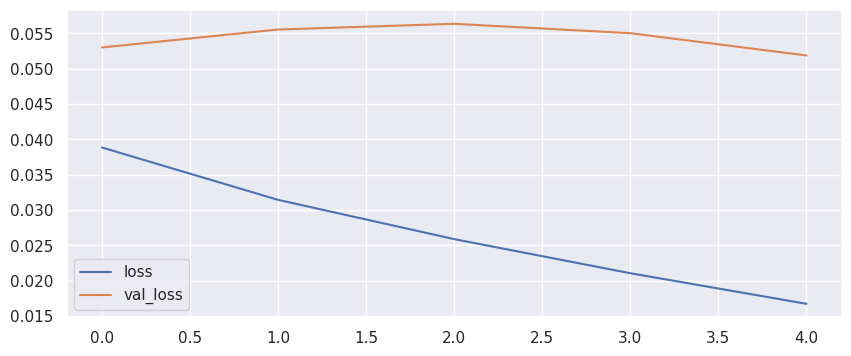

In [ ]:
# Train (small epochs for demo)
hist = lenet.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=128)
plot_history(hist, 'loss')

In [ ]:
# Evaluate
test_loss, test_acc = lenet.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', test_acc)

Test accuracy: 0.983299970626831


**Notes:** LeNet uses tanh/average pooling historically. Modern variants use ReLU and max-pooling; but LeNet is connected with ways of teaching.


# 5 — AlexNet-style model (adapted to CIFAR-10)

AlexNet is deeper and uses large kernels historically (11x11). For CIFAR-10 (32x32 images) we adapt the architecture.


Most important features of the AlexNet are:

Overfitting Prevention: Dropout (0.5) was applied to the first two fully connected layers and data augmentation dynamically expanded the dataset hence both helping in reducing overfitting.

Faster Training: ReLU activation was used instead of tanh or sigmoid, leading to a 6× speedup in training by avoiding activation saturation.

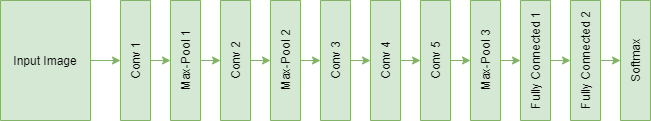

**5 convolutional layers** with Max-Pooling applied after the 1st, 2nd and 5th layers to enhance feature extraction.

**Overlapping Max-Pooling** uses a 3×3 filter with stride 2 which improved performance by reducing top-1 error by 0.4% and top-5 error by 0.3% compared to non-overlapping pooling.

Followed by **2 fully connected layers** each using dropout to prevent overfitting.

Ends with a **softmax layer** for final classification.

In [ ]:
# Load CIFAR-10 (color images)
(x_train_c, y_train_c), (x_test_c, y_test_c) = keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [ ]:
x_train_c = x_train_c.astype('float32')/255.0
x_test_c  = x_test_c.astype('float32')/255.0
x_train_c, x_val_c, y_train_c, y_val_c = train_test_split(x_train_c, y_train_c, test_size=0.1, random_state=SEED)

In [ ]:
# Simple AlexNet-like model adapted to CIFAR
def build_alexnet_like(input_shape=(32,32,3), num_classes=10):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(inp)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(192, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(384, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=inp, outputs=out)
    return model

In [ ]:
alex = build_alexnet_like()
alex.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
             loss='sparse_categorical_crossentropy', metrics=['accuracy'])
alex.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 192)    │       110,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 384)      │       663,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │        40,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,855,178 (136.78 MB)

 Trainable params: 35,855,178 (136.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train for a few epochs (for demo); consider using data augmentation for better performance
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

In [ ]:
batch_size = 128
train_gen = datagen.flow(x_train_c, y_train_c, batch_size=batch_size)
steps_per_epoch = len(x_train_c) // batch_size

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 36s 93ms/step - accuracy: 0.1658 - loss: 2.1980 - val_accuracy: 0.3500 - val_loss: 1.7533
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3438 - loss: 1.7729 - val_accuracy: 0.3386 - val_loss: 1.7986
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 33s 80ms/step - accuracy: 0.3584 - loss: 1.7424 - val_accuracy: 0.4580 - val_loss: 1.4690
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4453 - loss: 1.4752 - val_accuracy: 0.4438 - val_loss: 1.5153
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - accuracy: 0.4534 - loss: 1.5031 - val_accuracy: 0.5416 - val_loss: 1.2527
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5625 - loss: 1.3480 - val_accuracy: 0.5440 - val_loss: 1.2438
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - accuracy: 0.5282 - loss: 1.3151 - val_accuracy: 0.6080 - val_loss: 1.0876
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5234 - loss: 1.3735 - val_accu

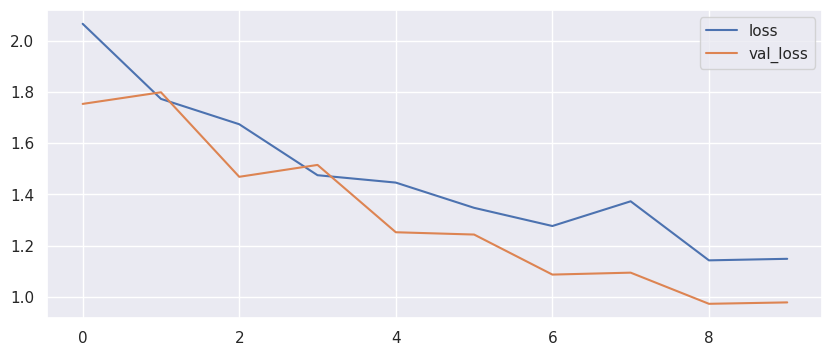

In [ ]:
hist_alex = alex.fit(train_gen, epochs=10, steps_per_epoch=steps_per_epoch, validation_data=(x_val_c, y_val_c))
plot_history(hist_alex, 'loss')

In [ ]:
# Evaluate
print('AlexNet-like eval:')
print(alex.evaluate(x_test_c, y_test_c, verbose=0))

AlexNet-like eval:
[0.9915050864219666, 0.6503000259399414]


approx. 65% accuracy on unseen test data

For a scratch-trained AlexNet on CIFAR-10 with only ~10 epochs, this is perfectly normal.

### Why Accuracy is Not Higher?

CIFAR-10 is 32×32 — much smaller than AlexNet’s original 224×224

Training only for 10 epochs is not enough

No aggressive data augmentation

No learning-rate scheduling

**Notes:** True AlexNet had local response normalization, large kernels, and was trained on ImageNet-sized images.
This adaptation is for learning.

# 6 — VGG (Transfer Learning) on CIFAR-10

VGG16 is deep, with repeated 3x3 convs. We'll use Keras `VGG16` pretrained on ImageNet and fine-tune on CIFAR-10.



The ImageNet dataset contains images of fixed size of 224*224 and have RGB channels. So, we have a tensor of (224, 224, 3) as our input. This model process the input image and outputs a vector of 1000 values

It is characterized by its depth, consisting of 16 layers including 13 convolutional layers and 3 fully connected layers.

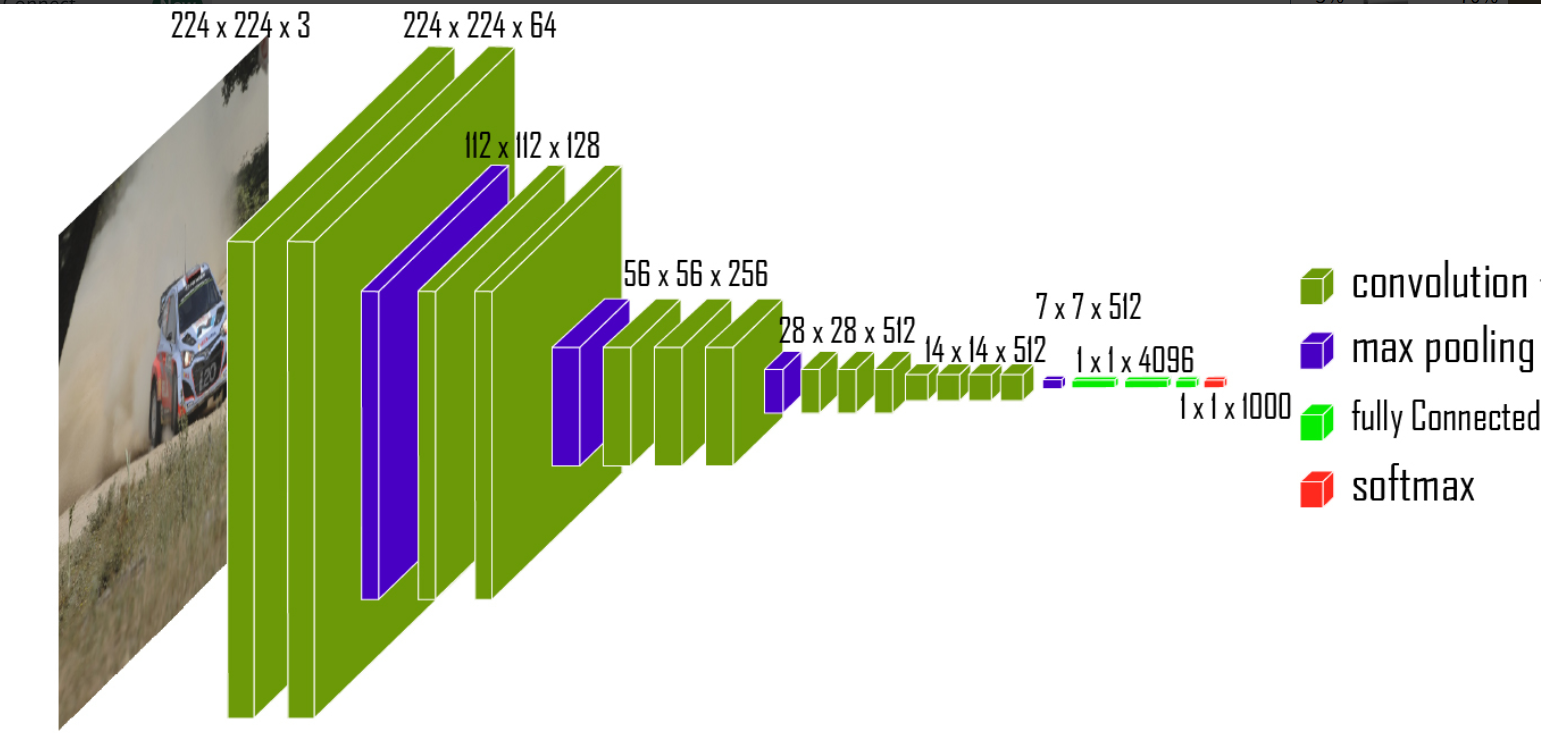

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
# Prepare CIFAR for VGG: resize to 48x48 or 64x64 (VGG expects >=48) — we'll resize to 48x48
import tensorflow as tf
IMG_SIZE = 48

In [ ]:
def resize_images(x):
    return tf.image.resize(x, (IMG_SIZE, IMG_SIZE)).numpy()

In [ ]:
x_train_v = resize_images(x_train_c)
x_val_v   = resize_images(x_val_c)
x_test_v  = resize_images(x_test_c)

In [ ]:
# Apply VGG preprocess
x_train_v = preprocess_input(x_train_v*255.0)
x_val_v   = preprocess_input(x_val_v*255.0)
x_test_v  = preprocess_input(x_test_v*255.0)

base = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE,3))
base.trainable = False  # freeze base


In [ ]:
inp = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
x = base(inp, training=False)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(10, activation='softmax')(x)

In [ ]:
vgg_model = models.Model(inp, out)
vgg_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
vgg_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 133,898 (523.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/6
704/704 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.4208 - loss: 4.7609 - val_accuracy: 0.6314 - val_loss: 1.0760
Epoch 2/6
704/704 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.5845 - loss: 1.2255 - val_accuracy: 0.6678 - val_loss: 0.9799
Epoch 3/6
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.6350 - loss: 1.0648 - val_accuracy: 0.6800 - val_loss: 0.9429
Epoch 4/6
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.6576 - loss: 0.9845 - val_accuracy: 0.6834 - val_loss: 0.9235
Epoch 5/6
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.6759 - loss: 0.9372 - val_accuracy: 0.6944 - val_loss: 0.9054
Epoch 6/6
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.6889 - loss: 0.8962 - val_accuracy: 0.6942 - val_loss: 0.9135


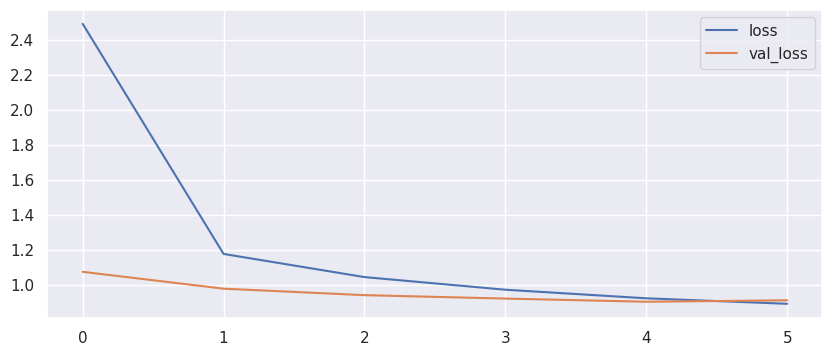

In [ ]:
hist_vgg = vgg_model.fit(x_train_v, y_train_c, validation_data=(x_val_v, y_val_c), epochs=6, batch_size=64)
plot_history(hist_vgg, 'loss')

Epoch 1/4
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 31s 19ms/step - accuracy: 0.7079 - loss: 0.8397 - val_accuracy: 0.6976 - val_loss: 0.9012
Epoch 2/4
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 0.7161 - loss: 0.8155 - val_accuracy: 0.6998 - val_loss: 0.8956
Epoch 3/4
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.7205 - loss: 0.8026 - val_accuracy: 0.7014 - val_loss: 0.8920
Epoch 4/4
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.7244 - loss: 0.7870 - val_accuracy: 0.7038 - val_loss: 0.8896


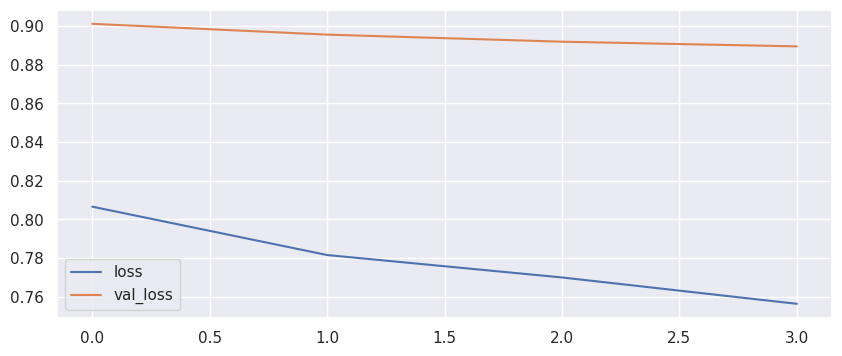

VGG eval:
[0.895344614982605, 0.6996999979019165]


In [ ]:
vgg_model.compile(optimizer=keras.optimizers.Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist_ft = vgg_model.fit(x_train_v, y_train_c, validation_data=(x_val_v, y_val_c), epochs=4, batch_size=32)
plot_history(hist_ft, 'loss')

print('VGG eval:')
print(vgg_model.evaluate(x_test_v, y_test_c, verbose=0))

VGG-based classifier correctly classifies ~70% of CIFAR-10 test images.

For a model trained on resized CIFAR-10 from scratch or with partially trained layers, 70% is completely normal.

VGG is extremely large (millions of parameters) and becomes slow to converge when:

training data is small (CIFAR-10 is only 50k images),

input is artificially upscaled (32→224 adds no detail),

pretrained weights are not fully fine-tuned.

**Notes:** Transfer learning often yields strong performance with less data and fewer epochs.


# 7 — Practical tips for applying CNNs to image data
1. Data preprocessing: normalize pixel ranges; for pretrained nets use their specific preprocess_input.
2. Data augmentation: random flips, crops, color jitter help generalization.
3. Regularization: dropout, weight decay (l2), and early stopping.
4. Learning rate schedules and optimizers: start with Adam or SGD with momentum; reduce LR on plateau.
5. Transfer learning: use pretrained backbones for small datasets.
6. Monitor validation metrics and inspect confusion matrices for class imbalance.


# 8 — Suggestions

- Use small epochs for speed during. For real training, increase epochs, use better augmentation, and save checkpoints.
- For larger real-world datasets, consider efficient architectures (ResNet, EfficientNet) for better performance.

- Try exercises:
  1. Replace AlexNet-like model with ResNet18;
  2. Try deeper VGG variants;
  3. Add Grad-CAM visualization for explainability.
